In [ ]:
!pip install -q missingno

In [ ]:
!pip install -q imbalanced-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape: (3576, 17)


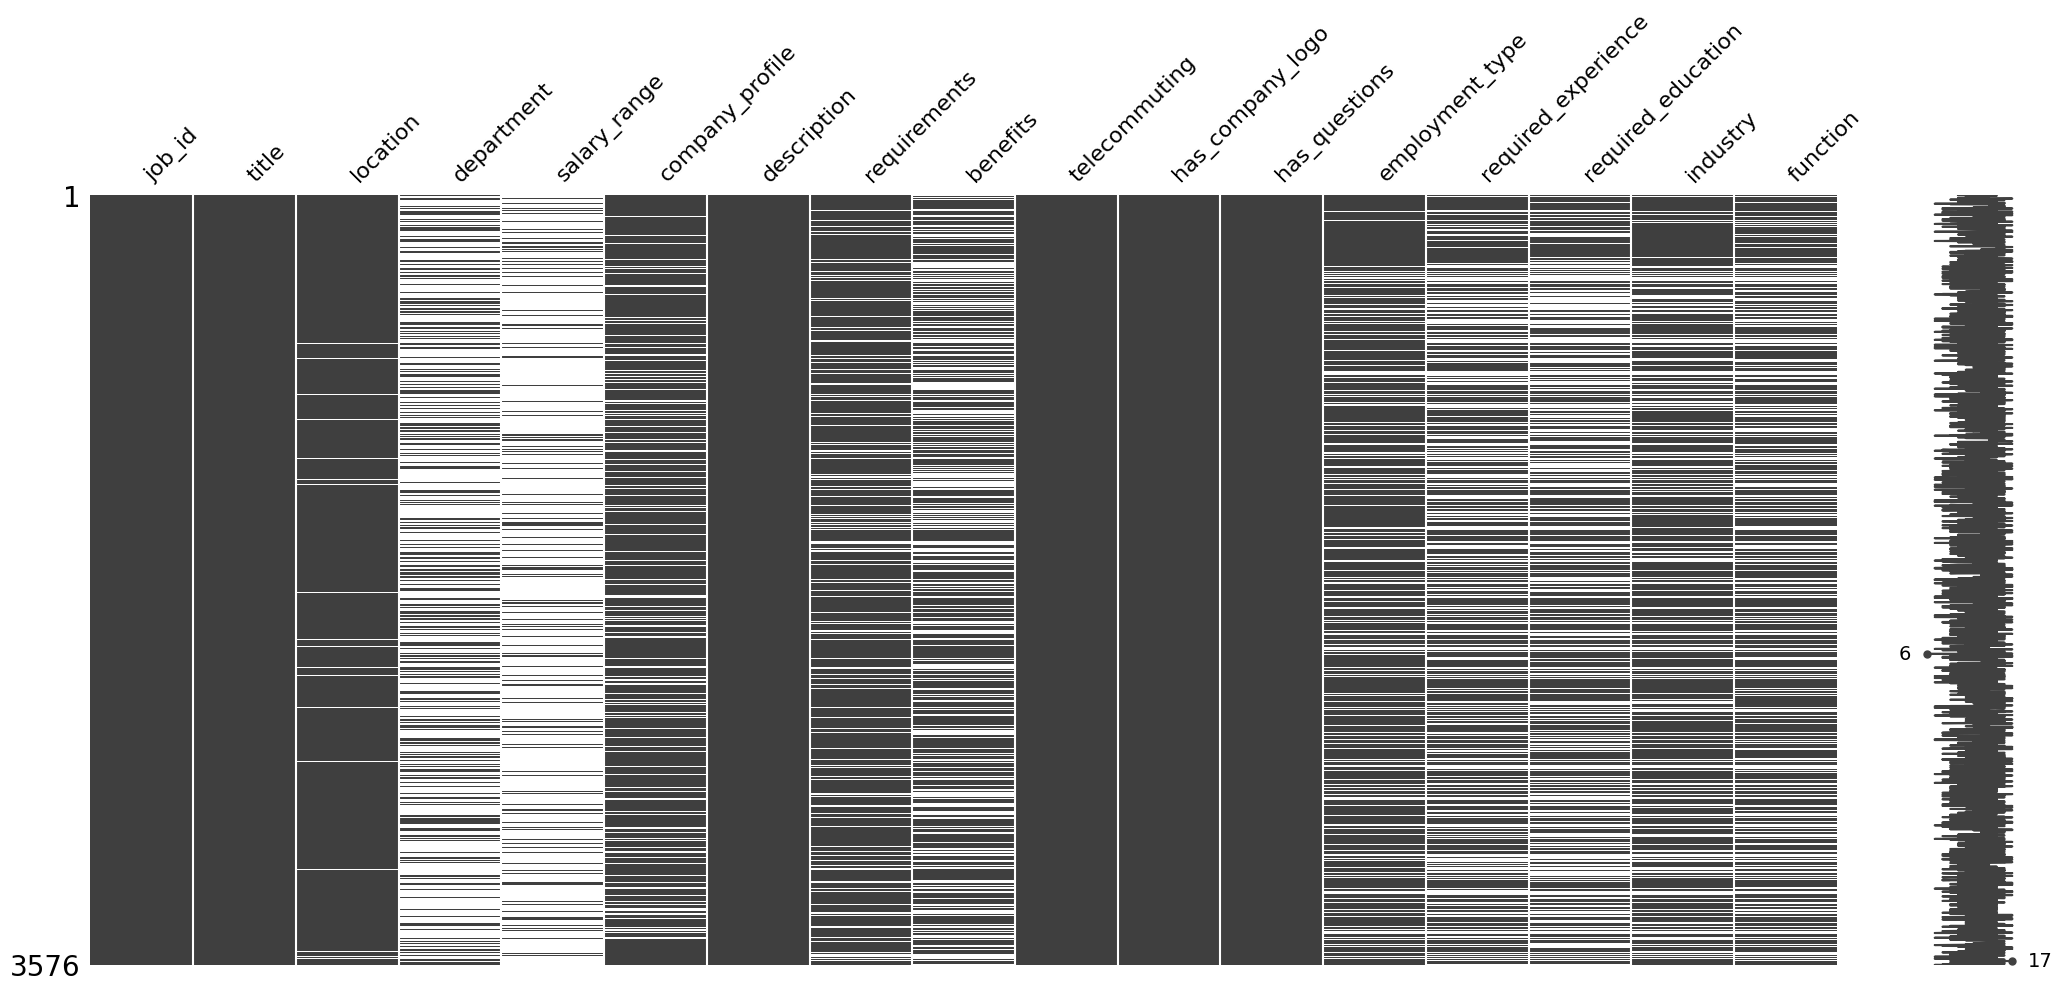

In [ ]:

file_path = '/content/drive/MyDrive/test.csv'
df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()
# Step 5: Visualize missing values
msno.matrix(df)
plt.show()


In [ ]:

# Step 6: Drop irrelevant columns and duplicates
drop_cols = ['job_id']
df.drop(columns=drop_cols, errors='ignore', inplace=True)
df.drop_duplicates(inplace=True)
print("After cleaning:", df.shape)

After cleaning: (3564, 16)


In [ ]:
# Step 7: Clean text columns
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_cols = ['title', 'location', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[col] = df[col].astype(str).apply(clean_text)


In [ ]:
# Step 8: Fill missing values in structured fields
cat_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
imp = SimpleImputer(strategy='mean')
df[num_cols] = imp.fit_transform(df[num_cols])


In [ ]:
import pandas as pd

# Load your cleaned or preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/test.csv")  # Update the path if needed

# Step 1: Define an enhanced suspicious keyword list
suspicious_keywords = [
    "wire transfer", "western union", "fee", "fees apply",
    "urgent", "immediate start", "no experience needed", "quick money",
    "get rich", "credit card", "investment required", "training fee",
    "money", "send payment", "pay to apply", "earn cash",
    "limited spots", "act now", "background check fee", "startup cost"
]

# Step 2: Function to flag presence of suspicious keywords in text
def keyword_flag(text):
    if pd.isnull(text):
        return 0
    text = text.lower()
    return int(any(keyword in text for keyword in suspicious_keywords))

# Step 3: Apply the flag to the 'description' column
df['suspicious_flag'] = df['description'].astype(str).apply(keyword_flag)

# Step 4: Save the updated DataFrame to a new CSV file
output_path = "/content/drive/MyDrive/cleaned_test_with_flag.csv"
df.to_csv(output_path, index=False)
print(f"Saved enhanced cleaned data to {output_path}")


Saved enhanced cleaned data to /content/drive/MyDrive/cleaned_test_with_flag.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_path = '/content/drive/MyDrive/cleaned_train_with_flag.csv'
df.to_csv(output_path, index=False)
print(f"Saved enhanced cleaned data to {output_path}")


Saved enhanced cleaned data to /content/drive/MyDrive/cleaned_train_with_flag.csv


In [ ]:
from google.colab import files
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Copy file to Colab local file system
!cp "/content/drive/MyDrive/cleaned_train.csv" "/content/cleaned_train.csv"

# Step 2: Download to your computer
from google.colab import files
files.download("/content/cleaned_train.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PHASE 2

In [ ]:
# Adjust path if needed
df = pd.read_csv('/content/drive/MyDrive/cleaned_train_with_flag.csv')
df.shape
!pip install -q scikit-learn

#ML

In [ ]:
# Install dependencies
!pip install -q imbalanced-learn xgboost

In [ ]:
import pickle
from xgboost import XGBClassifier

# Assuming X_train, y_train already defined
model = XGBClassifier()
model.fit(X_train, y_train)

# Save
with open('/content/drive/MyDrive/model_xgb.pkl', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Load data
df = pd.read_csv('/content/drive/MyDrive/cleaned_train_with_flag.csv')

# Drop job_id if present
if 'job_id' in df.columns:
    df = df.drop(columns=['job_id'])

# Combine text features
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_cols] = df[text_cols].fillna('')
df['text'] = df[text_cols].agg(' '.join, axis=1)

# Define input/output
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

# Feature groups
numeric_features = ['telecommuting', 'has_company_logo', 'has_questions', 'suspicious_flag']
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_transformer = TfidfVectorizer(
    stop_words='english',
    max_features=30000,
    ngram_range=(1, 2)
)

# Combine all features
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('txt', text_transformer, 'text')
])

# Define base classifiers
xgb = XGBClassifier(n_estimators=400, max_depth=7, learning_rate=0.08,
                    scale_pos_weight=6, use_label_encoder=False,
                    eval_metric='logloss', random_state=42)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

rf = RandomForestClassifier(n_estimators=250, random_state=42, class_weight='balanced_subsample')

# Stacked ensemble
stacked_model = StackingClassifier(
    estimators=[('xgb', xgb), ('logreg', logreg), ('rf', rf)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Final pipeline
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', stacked_model)
])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = model_pipeline.predict(X_val)
print("F1 Score (fraudulent class):", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:31:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:08:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

F1 Score (fraudulent class): 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2722
           1       0.95      0.76      0.84       139

    accuracy                           0.99      2861
   macro avg       0.97      0.88      0.92      2861
weighted avg       0.99      0.99      0.99      2861



In [ ]:
import joblib

# Save to local (optional)
joblib.dump(model_pipeline, '/content/model_pipeline.pkl')

# Save to Google Drive
joblib.dump(model_pipeline, '/content/drive/MyDrive/model_pipeline.pkl')


['/content/drive/MyDrive/model_pipeline.pkl']

In [ ]:
import joblib
model_pipeline.fit(X_train, y_train)

# Save the full fitted pipeline
joblib.dump(model_pipeline, '/content/drive/MyDrive/model_pipeline.pkl')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:53:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:02:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:11:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

['/content/drive/MyDrive/model_pipeline.pkl']

In [ ]:
import pandas as pd
import joblib
import numpy as np

# Load model
model = joblib.load('/content/drive/MyDrive/model_pipeline.pkl')

# Define expected columns
required_text = ['title', 'company_profile', 'description', 'requirements', 'benefits']
required_numeric = ['telecommuting', 'has_company_logo', 'has_questions', 'suspicious_flag']
required_categorical = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
all_required = required_text + required_numeric + required_categorical

# Suspicious keywords for flagging
suspicious_keywords = ['wire transfer', 'western union', 'fee', 'urgent', 'credit card', 'money', 'pay to apply']

def add_suspicious_flag(df):
    def keyword_flag(text):
        if pd.isnull(text):
            return 0
        return int(any(word in text.lower() for word in suspicious_keywords))
    df['suspicious_flag'] = df['description'].apply(keyword_flag)
    return df

def predict_jobs(csv_path, output_path='predictions.csv'):
    df = pd.read_csv(csv_path)

    # Add missing columns
    for col in all_required:
        if col not in df.columns:
            df[col] = np.nan

    # Add suspicious flag
    df = add_suspicious_flag(df)

    # Clean text and build 'text' field
    df[required_text] = df[required_text].fillna('')
    df['text'] = df[required_text].agg(' '.join, axis=1)

    # Drop job_id if exists
    if 'job_id' in df.columns:
        df = df.drop(columns=['job_id'])

    # Prepare input
    input_cols = required_numeric + required_categorical + ['text']
    X = df[input_cols]

    # Predict
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1]

    # Add to DataFrame
    df['fraudulent_pred'] = preds
    df['fraud_probability'] = probs

    # Save
    df.to_csv(output_path, index=False)
    print(f" Predictions saved to: {output_path}")

# Run it
predict_jobs('/content/drive/MyDrive/cleaned_test_with_flag.csv', '/content/drive/MyDrive/job_predictions.csv')


 Predictions saved to: /content/drive/MyDrive/job_predictions.csv


In [ ]:
# Define keywords indicating potential fraud
fraud_keywords = ['money', 'investment', 'bank', 'fee', 'urgent', 'limited', 'hiring', 'click', 'apply now', 'guaranteed', 'offer']

# Create keyword flag columns
def add_keyword_flags(df, keyword_list, text_column='description'):
    for keyword in keyword_list:
        df[f'flag_{keyword}'] = df[text_column].str.contains(keyword, case=False, na=False).astype(int)
    return df

# Apply on your DataFrame (replace `df` with your actual test/train set)
df = add_keyword_flags(df, fraud_keywords)


In [ ]:
!pip install shap

In [ ]:
import joblib

# Save
joblib.dump(model_pipeline, '/content/drive/MyDrive/model_pipeline.pkl')

# Load
model = joblib.load('/content/drive/MyDrive/model_pipeline.pkl')


 Sample Predictions Table:


,title,company_profile,fraudulent_pred,fraud_probability
0,excellent er rn opportunity available now,NaN,0,0.0010
1,scrum master website development project manager,inc is a fullservice digital agency creating w...,0,0.0002
2,hr assistant contract,squiz is one of the worlds leading web solutio...,0,0.0006
3,regional sales director south africa,upstreams mission is to revolutionise the way ...,0,0.0012
4,petrophysicist,valor services provides workforce solutions th...,0,0.0004
5,frontend developerhtmljavascriptcss,replise was started in just a year after twitt...,0,0.0020
6,software engineer,offerial is a hospitality technology startup h...,0,0.0001
7,customer service rep comed energy choice program,ny marketing firm is familyowned and operated ...,0,0.0022
8,web aspnetc developer remote,as a maestro commands notes instruments and ti...,0,0.0001
9,android developer,zylun is expanding the recruiting landscape fo...,0,0.0003


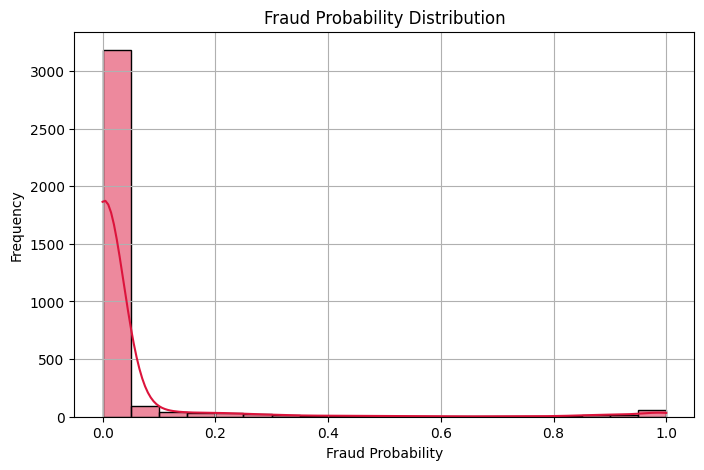

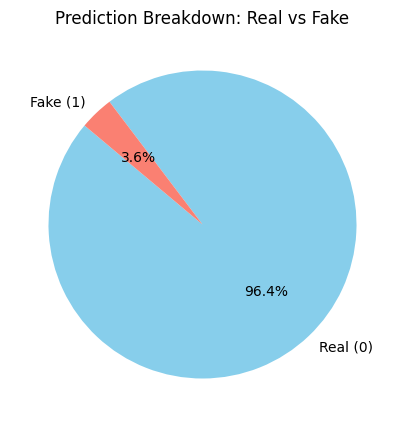

Top 10 Most Suspicious Job Listings:


,title,company_profile,fraud_probability
2336,home based payroll data entry clerk position e...,NaN,0.9998
2198,home based payroll data entry clerk position e...,NaN,0.9998
727,data entry office support,NaN,0.9995
2744,admin clerk remote position,NaN,0.9993
98,payroll data entry clerk position earn daily,NaN,0.9992
2102,payroll data entry clerk position earn daily,NaN,0.9992
2743,payroll data coordinator positions earn daily,NaN,0.9991
106,payroll data coordinator positions earn daily,NaN,0.9991
84,payroll data coordinator positions earn daily,NaN,0.9991
2814,data entry administrative assistant,NaN,0.9991


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load predictions
df = pd.read_csv('/content/drive/MyDrive/job_predictions.csv')  # adjust if needed

# Ensure necessary columns exist
required_cols = ['title', 'company_profile', 'fraudulent_pred', 'fraud_probability']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Round probabilities for neatness
df['fraud_probability'] = df['fraud_probability'].round(4)

# 1. Table of predictions
print(" Sample Predictions Table:")
display(df[['title', 'company_profile', 'fraudulent_pred', 'fraud_probability']].head(10))

# 2. Histogram of fraud probabilities
plt.figure(figsize=(8, 5))
sns.histplot(df['fraud_probability'], bins=20, kde=True, color='crimson')
plt.title('Fraud Probability Distribution')
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Pie chart: predicted real vs fake
counts = df['fraudulent_pred'].value_counts().sort_index()
labels = ['Real (0)', 'Fake (1)']
colors = ['skyblue', 'salmon']
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Prediction Breakdown: Real vs Fake')
plt.show()

# 4. Top 10 most suspicious listings
top_suspects = df.sort_values(by='fraud_probability', ascending=False).head(10)
print("Top 10 Most Suspicious Job Listings:")
display(top_suspects[['title', 'company_profile', 'fraud_probability']])

In [ ]:
!pip install shap


In [ ]:
import shap
import joblib
import pandas as pd

# Load model
model = joblib.load('/content/drive/MyDrive/model_pipeline.pkl')

# Load data
df = pd.read_csv('/content/drive/MyDrive/cleaned_train_with_flag.csv')
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_cols] = df[text_cols].fillna('')
df['text'] = df[text_cols].agg(' '.join, axis=1)

X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

# Subset for SHAP
X_sample = X.sample(100, random_state=42)
preprocessor = model.named_steps['preprocessor']
X_transformed = preprocessor.transform(X_sample)

# Use TreeExplainer for XGBoost (if in your ensemble)
explainer = shap.Explainer(model.named_steps['classifier'].predict, X_transformed)
shap_values = explainer(X_transformed)

# Plot SHAP summary
shap.plots.beeswarm(shap_values)


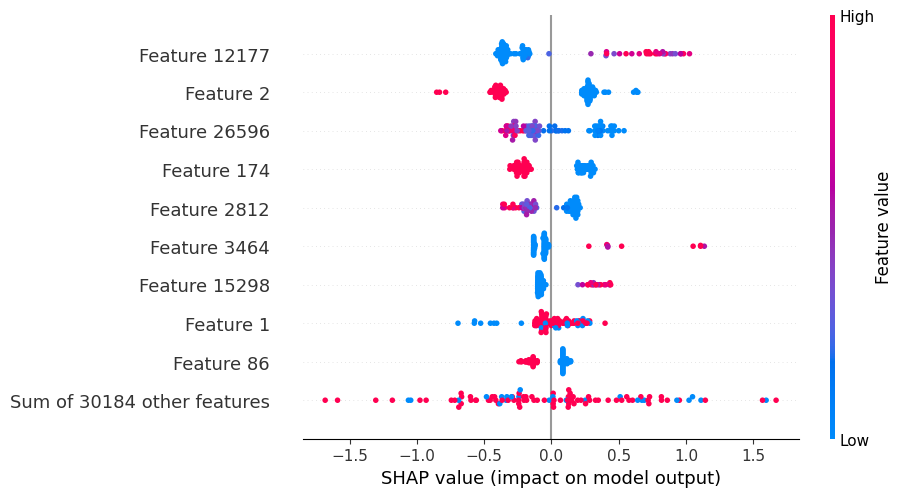

In [ ]:
import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load trained pipeline
model = joblib.load('/content/drive/MyDrive/model_pipeline.pkl')

# Extract preprocessor and XGBoost model from stacking classifier
preprocessor = model.named_steps['preprocessor']
stacking_classifier = model.named_steps['classifier']
xgb_model = stacking_classifier.named_estimators_['xgb']

# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/cleaned_train_with_flag.csv')

# Fill NA and construct 'text' field
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_cols] = df[text_cols].fillna('')
df['text'] = df[text_cols].agg(' '.join, axis=1)

# Select input features
numeric = ['telecommuting', 'has_company_logo', 'has_questions', 'suspicious_flag']
categorical = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
input_features = numeric + categorical + ['text']
X = df[input_features]

# Sample a small subset for SHAP (for speed)
X_sample = X.sample(100, random_state=42)

# Transform using the pipeline’s preprocessor
X_transformed_sparse = preprocessor.transform(X_sample)

# Convert sparse matrix to dense format
X_transformed = X_transformed_sparse.toarray()

# Use SHAP TreeExplainer for XGBoost model
explainer = shap.Explainer(xgb_model, X_transformed)
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.plots.beeswarm(shap_values)


In [ ]:
!ngrok config add-authtoken 2yVmSzLSViIVXIOkzJifSSebLhg_47x7SRcykFTSdNz83Grxy

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Install FastAPI and Uvicorn
!pip install fastapi uvicorn nest-asyncio pyngrok --quiet


In [ ]:

import nest_asyncio
nest_asyncio.apply()

from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import uvicorn
import pandas as pd
import numpy as np
from pyngrok import ngrok

# Load model
model = joblib.load('/content/drive/MyDrive/model_pipeline.pkl')

# Define the input schema
class JobListing(BaseModel):
    title: str
    company_profile: str
    description: str
    requirements: str
    benefits: str
    employment_type: str
    required_experience: str
    required_education: str
    industry: str
    function: str
    has_company_logo: int
    telecommuting: int
    has_questions: int
    suspicious_flag: int

# Initialize app
app = FastAPI()

@app.post("/predict")
def predict_job(job: JobListing):
    data = job.dict()
    df = pd.DataFrame([data])

    # Construct text field
    text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
    df['text'] = df[text_cols].agg(' '.join, axis=1)

    # Match input order to training
    input_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'suspicious_flag',
                  'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'text']

    pred = model.predict(df[input_cols])[0]
    prob = model.predict_proba(df[input_cols])[0][1]

    return {"prediction": int(pred), "probability": float(prob)}

# Start with ngrok tunnel
public_url = ngrok.connect(8000)
print("Public URL:", public_url)

uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [175]


Public URL: NgrokTunnel: "https://25ee-34-58-34-206.ngrok-free.app" -> "http://localhost:8000"


INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [175]


In [ ]:
import pandas as pd
import smtplib
from email.mime.text import MIMEText

def send_email_alert(row, to_email, from_email, smtp_server, smtp_port, login, password):
    subject = "⚠️ High-Risk Job Listing Detected"
    body = f"""\
A suspicious job listing was flagged:

Title: {row['title']}
Company: {row.get('company_profile', 'N/A')}
Fraud Probability: {row['fraud_probability']:.2f}

Please review immediately.
"""
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email

    try:
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()
            server.login(login, password)
            server.send_message(msg)
        print(f"Email sent for job: {row['title']}")
    except Exception as e:
        print(f"Error sending email: {e}")

def alert_high_risk_jobs(csv_path, threshold=0.85):
    df = pd.read_csv(csv_path)
    risky_jobs = df[df['fraud_probability'] >= threshold]

    # Email config (replace these)
    TO_EMAIL = "your@email.com"
    FROM_EMAIL = "alertbot@email.com"
    SMTP_SERVER = "smtp.gmail.com"
    SMTP_PORT = 587
    LOGIN = "your@email.com"
    PASSWORD = "yourpassword"  # App password if using Gmail 2FA

    for _, row in risky_jobs.iterrows():
        send_email_alert(row, TO_EMAIL, FROM_EMAIL, SMTP_SERVER, SMTP_PORT, LOGIN, PASSWORD)


In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

def retrain_model(csv_path, output_model_path):
    df = pd.read_csv(csv_path)
    text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
    df[text_cols] = df[text_cols].fillna('')
    df['text'] = df[text_cols].agg(' '.join, axis=1)

    numeric = ['telecommuting', 'has_company_logo', 'has_questions', 'suspicious_flag']
    categorical = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
    X = df[numeric + categorical + ['text']]
    y = df['fraudulent']

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', 'passthrough', numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('txt', TfidfVectorizer(max_features=3000), 'text')
    ])

    # Model
    clf = StackingClassifier(
        estimators=[('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))],
        final_estimator=LogisticRegression()
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    pipe.fit(X, y)
    joblib.dump(pipe, output_model_path)
    print(f"Model retrained and saved to {output_model_path}")
